In [2]:
from preprocess_image import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
try:
    img_drivers_df = pd.read_csv("driver_imgs_list.csv")
    print("Load dataset:{} {}".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Dataset could not be loaded. Is the dataset missing?


In [3]:
data.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_3384.jpg
freq,1237,2489,1


In [3]:
data.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
class_df = pd.DataFrame(index=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], columns=['Classname Count'])
class_df = class_df.fillna(0)

for index, row in data.iterrows():
    class_df.loc[row["classname"]] += 1

In [5]:
class_df.describe()

,Classname Count
count,10.000000
mean,2242.400000
std,175.387951
min,1911.000000
25%,2163.500000
50%,2314.500000
75%,2325.750000
max,2489.000000


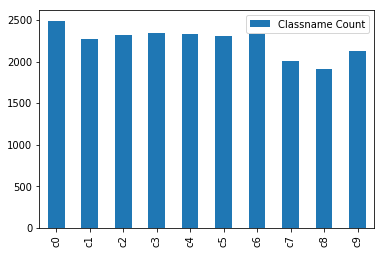

In [6]:
ax = class_df.plot(kind='bar')
plt.savefig("classname_count.png")
plt.show()
plt.close()

In [7]:
subject_dict = {}
subject_temp = ""
classname_temp = ""
driver_count = 0
driver_classname_count = 0
drivers_count = 0


def add_driver_subject_information(dict, subject, classname, count):
    if subject in dict:
        dict[subject].append(count)
    else:
        dict[subject] = [count]

for index, row in data.iterrows():
    if subject_temp is not row["subject"]:
        if driver_classname_count > 1:
            add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)
            driver_classname_count = 0

        subject_temp = row["subject"]
        driver_count = 1
        drivers_count += 1
    else:
        driver_count += 1
        if classname_temp is not row["classname"]:
            if driver_classname_count != 0:
                driver_classname_count += 1
                add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)
            classname_temp = row["classname"]
            driver_classname_count = 1
        else:
            driver_classname_count += 1
            
add_driver_subject_information(subject_dict, subject_temp, classname_temp, driver_classname_count)

In [8]:
subject_dict.keys()

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])

In [9]:
subject_df = pd.DataFrame(index=subject_dict.keys(),
                          columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for key in subject_dict.keys():
    subject_df.loc[key] = subject_dict[key]

print(subject_df)

       c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
p002   76   75   87   80   85   77   84   73   45   51
p012   84   96   92   90   98   97   76   73   63   62
p014  100  104  101  101  104  103  102   78   39   52
p015   79   86   89   95  102  102  100   82   87   61
p016  111  103  102  129  105  105  109  102  100  120
p021  135  132  128  129  133  131  127   99  100  131
p022  129  130  129  130  131  131  132   99   99  131
p024  130  130  129  131  130  132  130  102  100  120
p026  130  130  131  132  127  131  129   98   98   98
p035   94   82   89   90   90   90   95   88   57   81
p039   65   64   71   66   63   65   64   65   71   65
p041   60   65   61   61   61   62   62   62   60   59
p042   59   60   61   60   59   60   60   60   60   60
p045   75   76   77   76   76   77   72   68   67   68
p047   80   92   82   87   83   88   82   83   83   83
p049   84   86  120  111  110  117  120   75   80  116
p050  123   46   53   99   84   92   83   82   66   70
p051  182 

# 先训练C0

## 步骤

1. 找出每个标签下与该标签的驾驶状态不符的图片, 收集到outliers_dict上

In [4]:
outliers_dict = {}

In [28]:
def make_pic_filename(number):
    str = 'img_%s.jpg' % number
    return str

In [5]:
# 将异常值收集到异常值字典里
def append_outliers_to_dict(_dict, classname, outliers):
    _dict[classname] = outliers

In [30]:
def drop_outlier(origin_data, outliers):
    pic_filenames = [list(data['img']).index(make_pic_filename(x)) for x in outliers]
    new_df = origin_data.drop(origin_data.index[pic_filenames])
    return new_df

### 添加C0异常值

In [6]:
outliers = ['100074', '101091', '101392', '101419', '101555', '101668', '10514', '14552', '14757', '16927',
            '18680', '20144', '21155', '2151', '21699', '27453', '27568', '2843', '28578', '29350',
            '31032', '31659', '3349', '34028', '34380', '35327', '35809', '3600', '36287', '36854',
            '37728', '38288', '41079', '4335', '45005', '45571', '47447', '48931', '49150', '51985',
            '53288', '54712', '56120', '56251', '56357', '58013', '58551', '5963', '6002', '60226',
            '62095', '62383', '66097', '68134', '68246', '68266', '68629', '68630', '70795', '71478',
            '71483', '71499', '73825', '79194', '81035', '81735', '86913', '87245', '88085', '89173',
            '89653', '90273', '90865', '91414', '91777', '94842', '94969', '95252', '95596', '96741',
            '99515', '99779', '99846']
append_outliers_to_dict(outliers_dict, 'c0', outliers)

### 添加C1异常值

In [7]:
outliers = []
append_outliers_to_dict(outliers_dict, 'c1', outliers)

### 添加C2异常值

In [8]:
outliers = ['69693', '76349', '86001']
append_outliers_to_dict(outliers_dict, 'c2', outliers)

### 添加C3异常值

In [9]:
outliers = []
append_outliers_to_dict(outliers_dict, 'c3', outliers)

### 添加C4异常值

In [10]:
outliers = ['35657', '38427', '40343', '53828', '63738', '77347', '9170', '92769']
append_outliers_to_dict(outliers_dict, 'c4', outliers)

### 添加C5异常值

In [11]:
outliers = ['101079', '12442', '19127', '27454', '44224', '78504', '87062']
append_outliers_to_dict(outliers_dict, 'c5', outliers)

### 添加C6异常值

In [12]:
outliers = []
append_outliers_to_dict(outliers_dict, 'c6', outliers)

### 添加C7异常值

In [13]:
outliers = ['74115', '7414', '95214']
append_outliers_to_dict(outliers_dict, 'c7', outliers)

### 添加C8异常值

In [14]:
outliers = ['10080', '100814', '11324', '13465', '13480', '13438', '13868', '14072', '14084', '14560',
            '16971', '17480', '18737', '18970', '19323', '19616', '22941', '22971', '2378', '25081',
            '26296', '26736', '27663', '27671', '31158', '31174', '36457', '37314', '41462', '42490',
            '47484', '4853', '53436', '53620', '54379', '55008', '56078', '56122', '73917', '76663',
            '83361', '89614']
append_outliers_to_dict(outliers_dict, 'c8', outliers)

### 添加C9异常值

In [15]:
outliers = ['11675', '10917', '1125', '11528', '11675', '12000', '12001', '12154', '13253', '13396',
            '13762', '13982', '14737', '16428', '17355', '18759', '18819', '18997', '19209', '20002',
            '20688', '20775', '21708', '21897', '24030', '24134', '24554', '25913', '26043', '26484',
            '27342', '28025', '29320', '29556', '29906', '30092', '30172', '30893', '32125', '3318',
            '37262', '38453', '38742', '44953', '51826', '52610', '52861', '59747', '60004', '607',
            '61052', '60822', '60903', '61052', '62766', '66278', '67477', '68251', '69130', '69560',
            '69710', '7091', '71015', '75597', '77889', '78934', '81214', '83528', '83868', '8480',
            '8572', '87154', '89196', '91129', '96805', '97943']
append_outliers_to_dict(outliers_dict, 'c9', outliers)

In [16]:
outliers_dict['c0'][0]

'100074'

## 测试opencv

In [14]:
import cv2
from skimage.io import imread, imshow, imsave
img_sample = cv2.imread('../train/c0/img_100074.jpg')
img_sample.shape

(480, 640, 3)

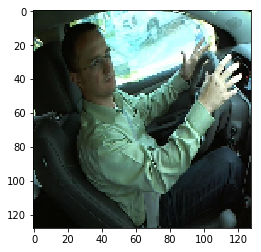

In [15]:
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
img_sample = cv2.resize(img_sample, (128, 128))
plt.imshow(img_sample)
plt.show()

In [16]:
img_sample.shape

(128, 128, 3)

## 预处理数据

### 将训练集数据量划出一半作为调试代码用

In [2]:
from skimage.io import imread, imshow, imsave
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import cv2
import os
import problem_unittests as tests

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
def random_sort(dataset):
    pass

In [27]:
def img_to_array(label, img_name, resize):
    img_load = cv2.imread('../train/%s/%s' % (label, img_name))
    img_load = cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB)
    img_load = cv2.resize(img_load, resize)
    return img_load

In [19]:
# 将训练集的数据量减半
def wrap_half_train_data(origin_df):
    new_df = origin_df.copy()
    columns = new_df.columns.tolist()
    for row, column in new_df.iterrows():
        for c_item in columns:
            new_df.loc[row, c_item] //= 2
    return new_df

In [ ]:
def index_by_classname(classname, class_list):
    if classname is 'c0':
        return 0
    else if classname is 

In [28]:
def load_features_labels(img_list_df):
    features_dict = {}
    labels_dict = {}
    classname_list = list(subject_df.columns)
    labels = one_hot_encode(classname_list)
    
    for index, row in img_list_df.iterrows():
        classname_item = row['classname']
        index = classname_list.index(classname_item)
        if classname_item in features_dict:
            features_dict[classname_item].append(img_to_array(classname_item, row['img'], (128, 128)))
            labels_dict[classname_item].append(labels[index])
        else:
            features_dict[classname_item] = [img_to_array(classname_item, row['img'], (128, 128))]
            labels_dict[classname_item] = [labels[index]]
            
    return features_dict, labels_dict

In [29]:
features_dict, labels_dict = load_features_labels(data)

### 将改变图像尺寸并保存到指定路径中

In [16]:
cnn_model_name = 'cnn/'
resize_image_directory = '../resize/'
origin_image_directory = '../train/'
cnn_train_image_directory = resize_image_directory + resize_image_directory + 'train/'

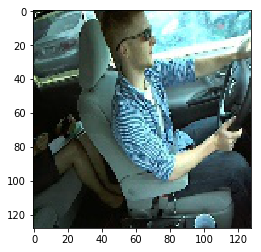

In [4]:
from preprocess_image import *
temp = load_image('img_100026.jpg', '../resize/cnn/train/c0', '../train/c0', (128, 128), show_image=True)

In [17]:
def get_image_number(image_name):
    return re.split(r"[_.]", image_name)

In [18]:
def is_outlier(image_name, class_name):
    image_number = get_image_number(image_name)
    image_array = outliers_dict[class_name]
    return image_number in image_array

In [19]:
def load_driver_feature(image_names, class_names, resize_path, origin_path, resize, show_image=False):
    image_array = []
    for image_name, class_name in zip(image_names, class_names):
        if is_outlier(image_name, class_name):
            continue
        resize_class_path = resize_path + '/' + class_name
        origin_class_path = origin_path + '/' + class_name
        image_array.append(load_image(image_name, resize_class_path, origin_class_path, resize, show_image))
    return image_array

In [21]:
image_names = img_drivers_df[img_drivers_df['subject'] == 'p002']['img'].values.tolist()
class_names = img_drivers_df[img_drivers_df['subject'] == 'p002']['classname'].values.tolist()
image_array = load_driver_feature(
    image_names,
    class_names,
    cnn_train_image_directory,
    origin_image_directory,
    (128, 128))

In [22]:
len(image_array)

725

In [ ]:
def train_test_split(img_list_df, subject_df):
    x = []
    y = []
    driver_count = 0
    labels = one_hot_encode(list(subject_df.columns))
    
    for index, row in data.iterrows():
        if row[]
        
    

In [83]:
subject_half_df = wrap_half_train_data(subject_df)
subject_half_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
p002,38,37,43,40,42,38,42,36,22,25
p012,42,48,46,45,49,48,38,36,31,31
p014,50,52,50,50,52,51,51,39,19,26
p015,39,43,44,47,51,51,50,41,43,30
p016,55,51,51,64,52,52,54,51,50,60


In [120]:
tests.test_one_hot_encode(one_hot_encode)

AssertionError: Encodings returned different results for the same numbers.
For the first call it returned:
[[0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
For the second call it returned
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]
Make sure you save the map of labels to encodings outside of the function.

In [129]:
one_hot_encode(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [132]:
list(subject_half_df.columns)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']